<a href="https://colab.research.google.com/github/falarion08/Isolation-Tree-from-scratch/blob/main/isolation_forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Isolation Forest Implementation from Scratch

Reference Paper :https://cs.nju.edu.cn/zhouzh/zhouzh.files/publication/icdm08b.pdf?q=isolation-forest


## Data Preprocessing

### Importing Library and dataset

In [ ]:
import pandas as pd
import numpy as np
from pathlib import Path
from google.colab import drive
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns

####**Context Regarding the dataset**

According to the World Health Organization (WHO) stroke is the 2nd leading cause of death globally, responsible for approximately 11% of total deaths.
This dataset is used to predict whether a patient is likely to get stroke based on the input parameters like gender, age, various diseases, and smoking status. Each row in the data provides relavant information about the patient.



**Attribute Information**

1) id: unique identifier

2) gender: "Male", "Female" or "Other"
3) age: age of the patient


4) hypertension: 0 if the patient doesn't have hypertension, 1 if the patient has hypertension

5) heart_disease: 0 if the patient doesn't have any heart diseases, 1 if the patient has a heart disease

6) ever_married: "No" or "Yes"

7) work_type: "children", "Govt_jov", "Never_worked", "Private" or "Self-employed"

8) Residence_type: "Rural" or "Urban"

9) avg_glucose_level: average glucose level in blood

10) bmi: body mass index

11) smoking_status: "formerly smoked", "never smoked", "smokes" or "Unknown"*

12) stroke: 1 if the patient had a stroke or 0 if not
*Note: "Unknown" in smoking_status means that the information is unavailable for this patient

In [ ]:
drive.mount('/gdrive')
%cd /gdrive

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive


In [ ]:
stroke_df = pd.read_csv('/content/healthcare-dataset-stroke-data.csv')
# stroke_dataset = Path('/gdrive/MyDrive/Colab Notebooks/healthcare-dataset-stroke-data.csv')
# stroke_df = pd.read_csv(stroke_dataset)
stroke_df

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,Female,80.0,1,0,Yes,Private,Urban,83.75,NaN,never smoked,0
5106,44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,37544,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


The dataset was downloaded from: https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset


### Cleaning null values

Examine the dataframe for null values

In [ ]:
stroke_df.isna().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

Since there are missing values, each observation that contains missing values will be dropped since they are only a small portion of the dataset

In [ ]:
# Drop values row-wise
stroke_df = stroke_df.dropna(axis=0)

### Remove Duplicates

In [ ]:
# Check if there are duplicates
stroke_df[stroke_df.duplicated()]

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke


There are no duplicates

###Preprocessing Categorical Data

In [ ]:
# Get all of the columns of the the dataframe that are numeric
num_cols = stroke_df._get_numeric_data().columns
df_cols = stroke_df.columns

# Get all categorical data in the stroke_df dataframe
categorical_cols = list(set(df_cols)-set(num_cols))

# For each categorical columns perform one hot encoder and use integer data type if the value is true
for col in categorical_cols:
  stroke_df = stroke_df.join(pd.get_dummies(stroke_df[col], prefix=col,dtype=int)).drop(columns=[col],axis=0)

display(stroke_df)

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,...,gender_Other,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Rural,Residence_type_Urban,ever_married_No,ever_married_Yes
0,9046,67.0,0,1,228.69,36.6,1,0,1,0,...,0,0,0,1,0,0,0,1,0,1
2,31112,80.0,0,1,105.92,32.5,1,0,0,1,...,0,0,0,1,0,0,1,0,0,1
3,60182,49.0,0,0,171.23,34.4,1,0,0,0,...,0,0,0,1,0,0,0,1,0,1
4,1665,79.0,1,0,174.12,24.0,1,0,0,1,...,0,0,0,0,1,0,1,0,0,1
5,56669,81.0,0,0,186.21,29.0,1,0,1,0,...,0,0,0,1,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5104,14180,13.0,0,0,103.08,18.6,0,1,0,0,...,0,0,0,0,0,1,1,0,1,0
5106,44873,81.0,0,0,125.20,40.0,0,0,0,1,...,0,0,0,0,1,0,0,1,0,1
5107,19723,35.0,0,0,82.99,30.6,0,0,0,1,...,0,0,0,0,1,0,1,0,0,1
5108,37544,51.0,0,0,166.29,25.6,0,0,1,0,...,0,0,0,1,0,0,1,0,0,1


##Building the Model

In [ ]:
# A class that represents the node in an isolation forest
class Node:
  def __init__(self,q,p,leftNode=None,rightNode=None,isLeaf=False,size=None):
    """
    Input:
    q - A string data type that represents a feature on a pandas dataframe
    p - A floating-point data that represents where the instance was partitioned
    rightNode- A Node datatype that represents the right child of the current node. Either null(if maximum depth is reached) or Node dataype
    lefthtNode- A Node datatype that represents the left child of the current node. Either null(if maximum depth is reached) or Node dataype
    size = An integer type value that represents the number of elements left in the input data when the maximum depth is reached.
    """
    self.leftNode = leftNode
    self.rightNode = rightNode
    self.splitAtt = q
    self.splitVal = p
    self.isLeaf = isLeaf
    self.size = size

class IsolationForest:
  def __init__(self,t=100,phi=256,anomaly_thresh=0.6):
    """
      t - number of trees. Default maximum size is 100
      phi - sub-sampling size. Controls the training data size. Default value is 256.
      anomaly_thresh - threshold value that will determine if a point is an anomaly or not. Default value is 0.60
    """
    self.t = t
    self.phi = phi
    self.anomaly_thresh = anomaly_thresh


  def initializeForest(self,train_data):
    """
      The function impelements the algorithm 1 of the paper. This is where the model will fit the data

      Input:
        train_data: A pandas dataframe where the model will be trained on

      Return: A list of Nodes that points to the head of the their respective tree
    """
    forest = []

    l = int(np.ceil(np.log2(self.phi))) # Compute for the height limit of each tree

    #  This function will create a set t iTrees
    for _ in range(self.t):
      X = train_data.sample(n=self.phi) # Take n samples from the training data
      forest.append(self.isolationTree(X,0,l))

    self.forest = forest
    return forest

  def isolationTree(self,X,e,l):
    """
    Impelements the Algorithm 2 of the paper.
    Input:
      X- A pandas data frame that represesnts the input data
      e- An integer data that represents the current tree height
      l - An integer data that represents the height limit

    Return: A Node from the isolation Tree
    """

    # Base case of the recursive function. Checks if the hight limit is reached or there is no more data from the input data to be partitioned
    if e >= l or X.shape[0] <= 1:
      return Node(q= None, p = None, isLeaf = True,size=X.shape[0])

    else:

      feature = self.selectRandomFeature(X) # Select random feature from the test data
      split_point = self.selectSplitPoint(feature,X) # Select a value between the minimum and maximum value of the feature in the test_data where the partition will happen

      # Partition the data
      X_left = X.loc[X[feature] < split_point].copy()
      X_right = X.loc[X[feature] >= split_point].copy()


      return Node(q=feature,
                  p=split_point,
                  leftNode = self.isolationTree(X_left,e+1,l),
                  rightNode = self.isolationTree(X_right,e+1,l))

  def selectRandomFeature(self,X):
    """
      Randomly select a feature from a given dataframe

      Input:
      X- A pandas dataframe. Represents the training data.

      Return: A string data type that represesnts the chosen feature
    """
    return np.random.choice(X.columns,size=1)[0]

  def selectSplitPoint(self,feature,X):
    """
      Selects a random attribute from the minimum value and maximum value from the selected attribute in dataframe X

      Input:
      feature- A string data type that represents which feature of the dataframe will the partition be made.
      X- A pandas dataframe. Represents the training data from the recursive function in the isolation Tree

      Return: A floating point value where the partition will be made
    """
    min = X[feature].min()
    max = X[feature].max()

    return  np.random.uniform(low=min, high=max+0.0001, size=1)[0] # Select data from [X[feature].min(),X[feature].max()] inclusive.


  def pathLength(self,instance,iTree,e=0):

    # Check if an external node. The base case for the recursive function
    if iTree.isLeaf:
      return e + self.c(iTree.size)

    e = e + 1 # Increase height
    feature = iTree.splitAtt
    if instance[feature] < iTree.splitVal:
      return self.pathLength(instance,iTree.leftNode,e)
    else:
      return self.pathLength(instance,iTree.rightNode,e)

  def evaluate_instance(self,instance):
    """
    Performs the evaluating stage and computes for the expected path lngth. Expected path length, E(h(x)), is derived by passing passing each test instance
    through each itree in the forest.

    Input:
      instance - A pandas series that represents a single datapoint from the training data

    Return: A list floating-point values that represent a single path length from the root node to the terminating node
    """
    paths = []
    for tree in self.forest:
        paths.append(self.pathLength(instance,tree))

    return paths

  def c(self,n):
    """
    This function computes for the average path length of of unsucessful search in BST.

    Input:
    n - Number of instances

    Return: A floating-point number or 0
    """

    # Only perform the computation when the number of instance, n, is greater than 1 else return a value of 0
    return  (2 * np.log(n-1) + 0.5772156649) - (2 * (n-1) / n) if n > 1 else 0

  def anomaly_score(self,test_data):
    """
      Computes for the anomaly score based from the reference paper.

      Input:
      test_data: A pandas dataframe. Each observations in the dataframe represents a single instance

      Return: List of floating-point data that represents the computed score for each instance
    """
    n = test_data.shape[0]
    c = self.c(n)

    # A lambda function that computes for the anomaly score of a single data point
    E = lambda i: np.round(np.power(2,-1*np.mean(self.evaluate_instance(i))/ c),2)


    scores = test_data.apply(E,axis=1).tolist() # Perform the computation in the pandas dataframe row-wise
    return scores

  def predict(self,test_data):
    """
    This function will make prediction on each datapoint in the test_data dataframe.
    A datapoint is considered an anomaly if the anomaly score is >= threshold value.
    Each data point is either map to 1 or 0 where:

    1 - Anomaly
    0 - Normal

    Input:
    test_data - A pandas dataframe that the model will make predictions on

    Return: A list of integer of containing 1s and 0s
    """
    scores = self.anomaly_score(test_data) # Returns a list of floating point data type that represesnts the score

    # Evaluate each index in the scores list if it is an anomaly or name given the threshold value
    predicted =  list(map(lambda x: 1 if x >= self.anomaly_thresh else 0,
                          scores))
    return predicted

  def fit_predict(self, data):
    """
    This function will perform will initialize a forest then predicts whether each data point is an anomaly or not.

    Input:
    data - A pandas dataframe that that is the input value and the model will make predictions on

    Returns : List of integers of 1 and 0 indicating if it is an anomaly or not
    """
    self.initializeForest(data)
    return self.predict(data)



##Simulating the model

In [ ]:
# Split the dataframe into train and test data only 30% of the original data will go to test
train,test = train_test_split(stroke_df,test_size = 0.3)

#  Create an instance of the model
iForest = IsolationForest()

# Fit the model
iForest.initializeForest(train)

# Make predictions on the test data
predicted = iForest.predict(test)

test_copy_df = test.copy()

# Save the predicted score to the dataframe
test_copy_df['isAnomaly'] = predicted


Plotting the result

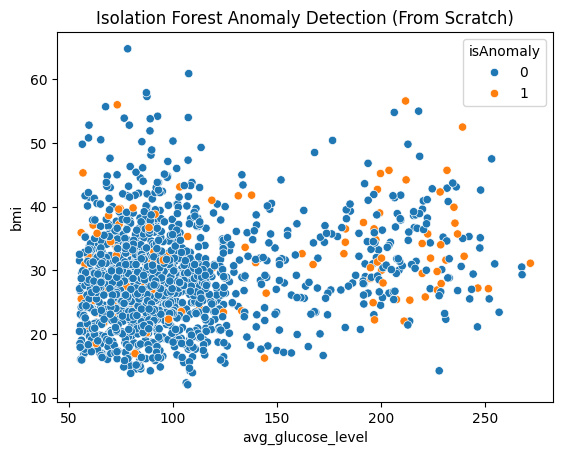

In [ ]:
fig,ax = plt.subplots()

ax = sns.scatterplot(x="avg_glucose_level", y="bmi",
                     hue="isAnomaly",
                     data=test_copy_df)
ax.set_title('Isolation Forest Anomaly Detection (From Scratch)')
plt.show()

Run Model on a random data

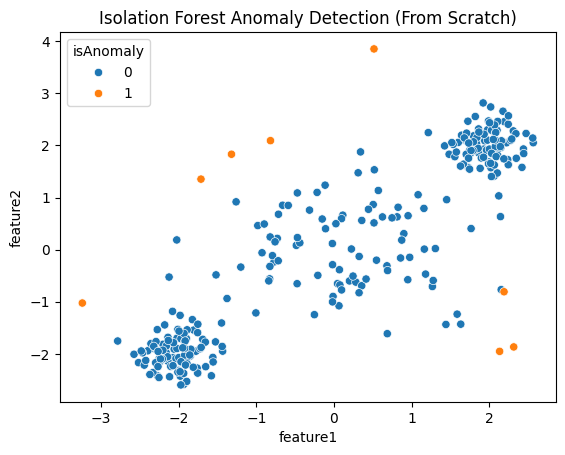

In [ ]:
rng = np.random.RandomState(42)
X = 0.3 * rng.randn(100, 2)
X = np.r_[X + 2, X - 2]
X = np.r_[X, rng.randn(100, 2)]

df = pd.DataFrame(X, columns=['feature1', 'feature2'])

# Fit the model
clf = IsolationForest()
clf.initializeForest(df)

# Predict anomalies
predictions = clf.predict(df)
df['isAnomaly'] = predictions

fig,ax = plt.subplots()

ax = sns.scatterplot(x="feature1", y="feature2",
                     hue="isAnomaly",
                     data=df)
ax.set_title('Isolation Forest Anomaly Detection (From Scratch)')
plt.show()

## Difference between Isolation Forest and Random Forest